# Feature Tracking with Sparse Optical Flow (KLT)

## Assignment: ELE14101 - Computer Vision - Object Tracking

**Student:** : ....

---

## Objective
To understand and implement the Kanade-Lucas-Tomasi (KLT) feature tracking algorithm, a foundational technique for analyzing motion and building stabilizers.

1. Giới thiệu
**Optical Flow là gì?**
- Optical Flow (hay Luồng quang học) là quy luật chuyển động biểu kiến của các vật thể trong một khung cảnh, được tạo ra bởi sự chuyển động tương đối giữa người quan sát (camera) và khung cảnh đó. Hiểu đơn giản, nó giúp ước tính vector chuyển động của các pixel giữa các khung hình liên tiếp nhau.

**So sánh Optical Flow thưa (Sparse) và dày (Dense)**
- Dense Optical Flow (Optical Flow dày): Tính toán vector chuyển động cho TẤT CẢ các pixel trong khung hình (ví dụ: phương pháp Farneback).

- Ưu điểm: Cung cấp thông tin chuyển động trọn vẹn, đầy đủ chi tiết.

- Nhược điểm: Chi phí tính toán rất lớn, tốc độ xử lý chậm.

- Sparse Optical Flow (Optical Flow thưa): Chỉ theo dõi một tập hợp con các điểm đặc trưng (như các góc, cạnh).

- Ưu điểm: Nhanh, hiệu quả, tập trung vào các đặc trưng nổi bật (salient features).

- Nhược điểm: Chỉ cung cấp thông tin chuyển động cục bộ/một phần.

**Thuật toán KLT (Kanade-Lucas-Tomasi) là gì?**

KLT là một phương pháp Sparse Optical Flow hoạt động theo quy trình:

1. Phát hiện "các đặc trưng tốt để theo dõi" (good features to track) - thường là các góc mạnh có sự thay đổi độ sáng (gradient) lớn.

2. Theo dõi các đặc trưng này qua các khung hình bằng cách sử dụng kỹ thuật Lucas-Kanade theo mô hình kim tự tháp (pyramidal implementation).

3. Dựa trên giả định rằng độ sáng không đổi (brightness constancy) và chuyển động giữa các khung hình là nhỏ.

**Các ứng dụng chính:**

- Ước tính chuyển động của camera

- Chống rung video (Video stabilization)

- Tái tạo 3D

- Theo dõi đối tượng (Object tracking)

- Cấu trúc từ chuyển động (Structure from Motion - SfM)

## 2. Methodology

### Algorithm Pipeline

Thuật toán theo dõi KLT tuân theo các bước sau:

1. **Khởi tạo (Initialization):**
   - Tải video và đọc frame đầu tiên
   - Chuyển đổi sang ảnh xám (grayscale)
   - Detect strong corners using `cv2.goodFeaturesToTrack()`
   - Store as `old_gray` and `old_points`

2. **Tracking Loop (for each new frame):**
   ```
      a. Đọc new_frame → Chuyển đổi thành new_gray
      b. Gọi hàm cv2.calcOpticalFlowPyrLK(old_gray, new_gray, old_points, None)
      c. Lọc các điểm tốt (good points) dựa trên mảng status
      d. Vẽ các vector chuyển động (đường nối từ vị trí cũ → vị trí mới)
      e. Cập nhật: old_gray = new_gray, old_points = good_new
      f. (Tùy chọn) Phát hiện lại các đặc trưng khi số lượng điểm giảm xuống dưới ngưỡng
   ```

3. **Visualization:**
   - Vẽ các đường thẳng thể hiện quỹ đạo chuyển động
   - Vẽ các vòng tròn tại vị trí hiện tại của điểm đặc trưng
   - Hiển thị từng khung hình hoặc lưu lại thành video
### Key Parameters

- **goodFeaturesToTrack:**
  - `maxCorners`: Số lượng góc tối đa cần phát hiện
  - `qualityLevel`: Chất lượng tối thiểu của các góc (trong khoảng 0-1)
  - `minDistance`: Khoảng cách Euclidean tối thiểu giữa các góc (để tránh các điểm quá gần nhau)
  
- **calcOpticalFlowPyrLK:**
  - `winSize`: Window size for search
  - `maxLevel`: Pyramid levels (0 = no pyramid)
  - Returns: `new_points`, `status` (1=found, 0=not found), `error`

## 3. Implementation

### Import Required Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, Image, display
import os

print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)

OpenCV version: 4.8.1
NumPy version: 1.26.4


### Configuration Parameters

In [6]:
# Parameters for goodFeaturesToTrack
feature_params = dict(
    maxCorners=100,      # Maximum number of corners to detect
    qualityLevel=0.3,    # Quality level (0-1), minimum quality of corners
    minDistance=7,       # Minimum Euclidean distance between corners
    blockSize=7          # Size of averaging block for corner detection
)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(
    winSize=(15, 15),    # Window size for search
    maxLevel=2,          # Maximum pyramid level (0 = no pyramid)
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Video settings
VIDEO_INPUT = "Easy.mp4"  # Input video file
VIDEO_OUTPUT = "klt_tracking_output.avi"  # Output video file
DISPLAY_REALTIME = False     # Set True to display while processing
FEATURE_REFRESH_THRESHOLD = 15  # Re-detect features when count drops below this

print("Configuration loaded successfully!")

Configuration loaded successfully!


### Main KLT Tracking Function

In [7]:
def klt_feature_tracking(video_path, output_path=None, display=False, feature_refresh_threshold=15):
    """
    Perform KLT (Kanade-Lucas-Tomasi) feature tracking on a video.
    
    Parameters:
    -----------
    video_path : str
        Path to input video file
    output_path : str, optional
        Path to save output video (if None, won't save)
    display : bool
        Whether to display tracking in real-time
    feature_refresh_threshold : int
        Re-detect features when count drops below this value
        
    Returns:
    --------
    frames_with_tracking : list
        List of frames with tracking visualization
    statistics : dict
        Tracking statistics
    """
    
    # Open video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video info: {width}x{height} @ {fps}fps, {total_frames} frames")
    
    # Initialize video writer if output path provided
    out = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Read first frame
    ret, old_frame = cap.read()
    if not ret:
        raise ValueError("Cannot read first frame")
    
    # Convert to grayscale
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    
    # Detect initial feature points using Shi-Tomasi corner detector
    old_points = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    
    if old_points is None:
        raise ValueError("No features detected in first frame")
    
    print(f"Initial features detected: {len(old_points)}")
    
    # Create random colors for visualization
    colors = np.random.randint(0, 255, (100, 3))
    
    # Create a mask for drawing motion trails
    mask = np.zeros_like(old_frame)
    
    # Statistics
    frames_with_tracking = []
    frame_count = 0
    feature_refresh_count = 0
    
    # Main tracking loop
    while True:
        ret, new_frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        new_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow using Lucas-Kanade method
        new_points, status, error = cv2.calcOpticalFlowPyrLK(
            old_gray, new_gray, old_points, None, **lk_params
        )
        
        # Filter good points (successfully tracked)
        if new_points is not None:
            good_new = new_points[status == 1]
            good_old = old_points[status == 1]
        else:
            good_new = np.array([])
            good_old = np.array([])
        
        # Draw motion vectors (quiver plot)
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            a, b, c, d = int(a), int(b), int(c), int(d)
            
            # Draw line (motion vector) from old to new position
            mask = cv2.line(mask, (c, d), (a, b), colors[i % 100].tolist(), 2)
            
            # Draw circle at current position
            new_frame = cv2.circle(new_frame, (a, b), 5, colors[i % 100].tolist(), -1)
        
        # Combine frame with motion trails
        output_frame = cv2.add(new_frame, mask)
        
        # Add text overlay
        cv2.putText(output_frame, f"Frame: {frame_count}/{total_frames}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(output_frame, f"Features: {len(good_new)}", 
                    (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Save frame
        frames_with_tracking.append(output_frame.copy())
        
        # Write to output video
        if out:
            out.write(output_frame)
        
        # Display if requested
        if display:
            cv2.imshow('KLT Feature Tracking', output_frame)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break
        
        # Update for next iteration
        old_gray = new_gray.copy()
        old_points = good_new.reshape(-1, 1, 2)
        
        # Re-detect features if too few remain (Advanced feature)
        if len(good_new) < feature_refresh_threshold:
            print(f"Frame {frame_count}: Re-detecting features ({len(good_new)} remaining)")
            new_features = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
            
            if new_features is not None:
                old_points = new_features
                feature_refresh_count += 1
                # Clear the motion trail mask for cleaner visualization
                mask = np.zeros_like(old_frame)
        
        # Progress indicator
        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames} frames...")
    
    # Cleanup
    cap.release()
    if out:
        out.release()
    if display:
        cv2.destroyAllWindows()
    
    statistics = {
        'total_frames': frame_count,
        'feature_refreshes': feature_refresh_count,
        'video_dimensions': (width, height),
        'fps': fps
    }
    
    print(f"\nTracking completed!")
    print(f"Total frames processed: {frame_count}")
    print(f"Feature refreshes: {feature_refresh_count}")
    if output_path:
        print(f"Output saved to: {output_path}")
    
    return frames_with_tracking, statistics

### Run KLT Tracking on Video

In [15]:
# Run KLT tracking
try:
    frames, stats = klt_feature_tracking(
        video_path=VIDEO_INPUT,
        output_path=VIDEO_OUTPUT,
        display=DISPLAY_REALTIME,
        feature_refresh_threshold=FEATURE_REFRESH_THRESHOLD
    )
    print("\n✓ Tracking completed successfully!")
except Exception as e:
    print(f"✗ Error during tracking: {e}")

Video info: 640x360 @ 29fps, 914 frames
Initial features detected: 17
Processed 30/914 frames...
Processed 60/914 frames...
Processed 90/914 frames...
Processed 60/914 frames...
Processed 90/914 frames...
Processed 120/914 frames...
Processed 150/914 frames...
Processed 120/914 frames...
Processed 150/914 frames...
Processed 180/914 frames...
Frame 185: Re-detecting features (14 remaining)
Frame 186: Re-detecting features (11 remaining)
Frame 187: Re-detecting features (10 remaining)
Frame 188: Re-detecting features (10 remaining)
Frame 189: Re-detecting features (11 remaining)
Frame 190: Re-detecting features (12 remaining)
Frame 191: Re-detecting features (12 remaining)
Frame 192: Re-detecting features (13 remaining)
Frame 193: Re-detecting features (10 remaining)
Frame 194: Re-detecting features (9 remaining)
Frame 195: Re-detecting features (12 remaining)
Frame 196: Re-detecting features (8 remaining)
Frame 197: Re-detecting features (11 remaining)
Frame 198: Re-detecting features 

## 4. Results and Visualization

### Display Sample Frames

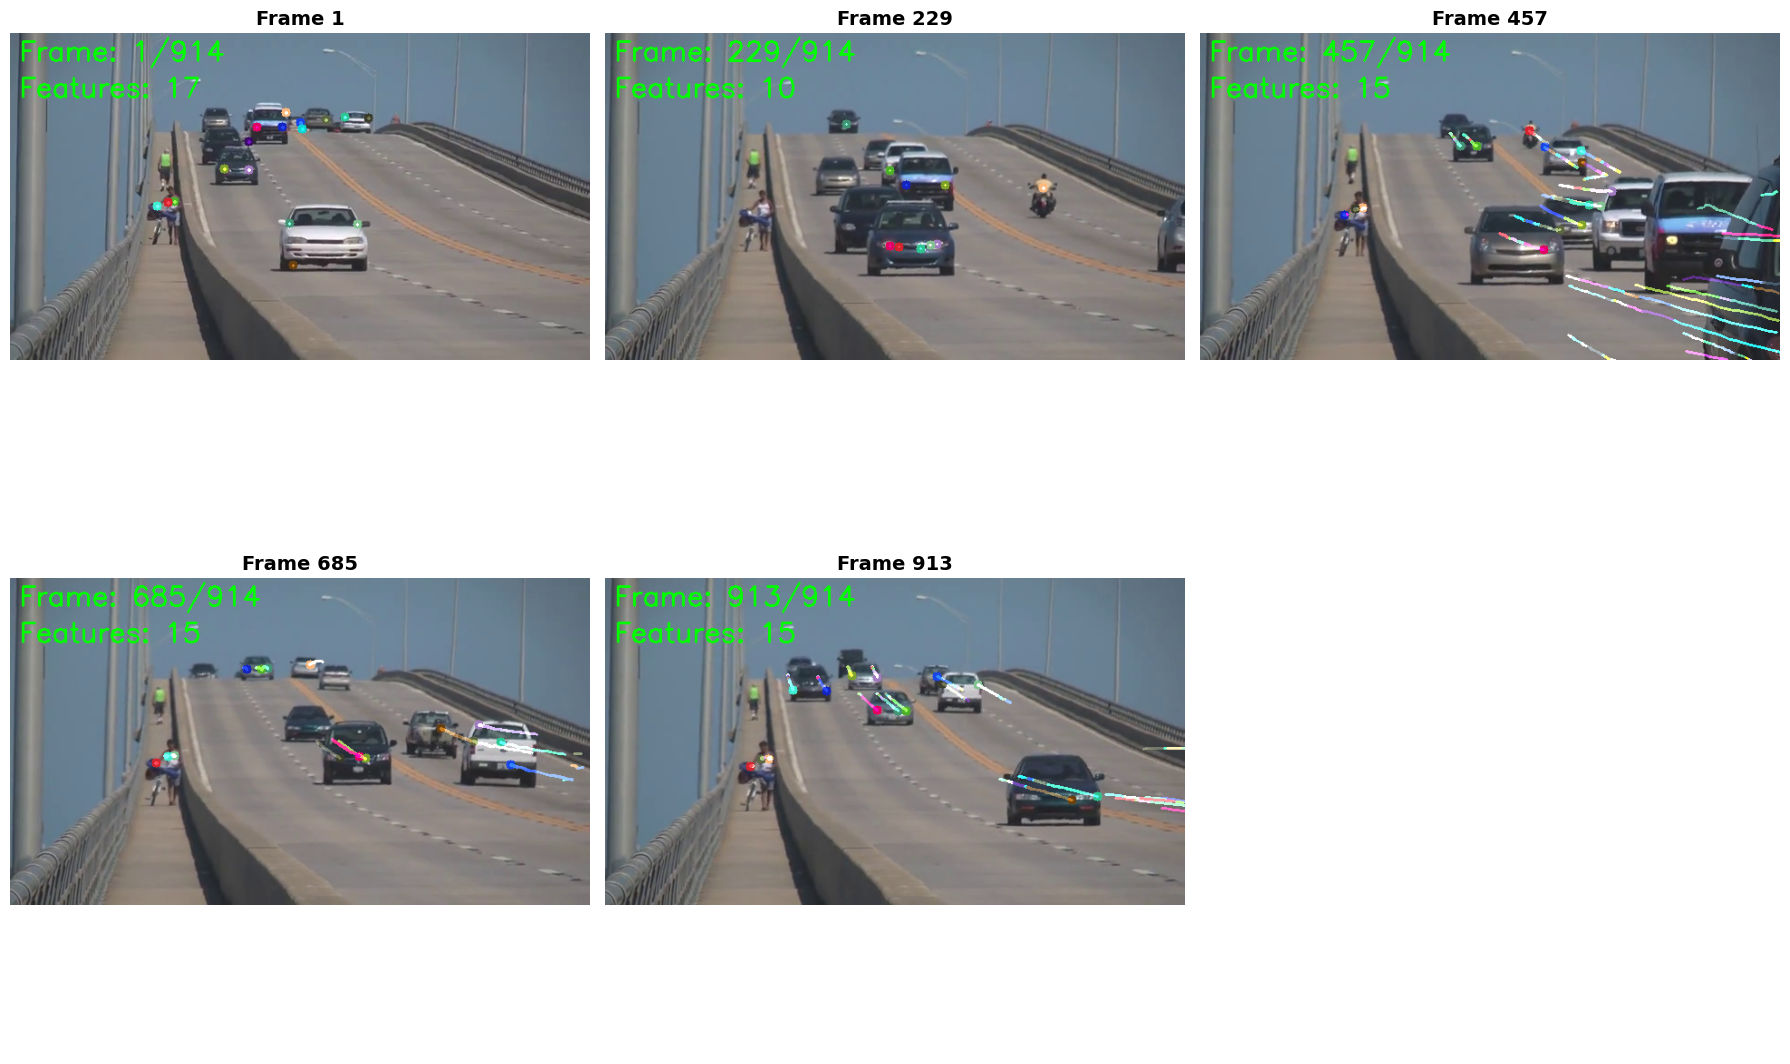

Sample frames displayed and saved to 'klt_tracking_samples.png'


In [16]:
# Display sample frames from the tracking result
if len(frames) > 0:
    # Select frames to display: start, middle, and end
    sample_indices = [0, len(frames)//4, len(frames)//2, 3*len(frames)//4, len(frames)-1]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, frame_idx in enumerate(sample_indices):
        if frame_idx < len(frames):
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB)
            axes[idx].imshow(frame_rgb)
            axes[idx].set_title(f'Frame {frame_idx+1}', fontsize=14, fontweight='bold')
            axes[idx].axis('off')
    
    # Hide the last subplot if not used
    axes[-1].axis('off')
    
    plt.tight_layout()
    plt.savefig('klt_tracking_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Sample frames displayed and saved to 'klt_tracking_samples.png'")
else:
    print("No frames to display")

### Display Output Video

In [20]:
# Convert AVI to MP4 for better browser compatibility
import subprocess

output_mp4 = "klt_tracking_output.mp4"

if os.path.exists(VIDEO_OUTPUT):
    try:
        # Try using ffmpeg if available
        result = subprocess.run(
            ['ffmpeg', '-y', '-i', VIDEO_OUTPUT, '-c:v', 'libx264', '-preset', 'fast', 
             '-crf', '23', '-c:a', 'copy', output_mp4],
            capture_output=True,
            text=True
        )
        if result.returncode == 0:
            print(f"✓ Converted to MP4: {output_mp4}")
            print(f"File size: {os.path.getsize(output_mp4) / (1024*1024):.2f} MB")
            display(Video(output_mp4, width=800))
        else:
            print("⚠ FFmpeg not available, displaying AVI directly")
            print("Note: Some browsers may not play MJPEG codec well")
            # Try HTML5 video player as alternative
            from IPython.display import HTML
            video_tag = f'''
            <video width="800" controls>
                <source src="{VIDEO_OUTPUT}" type="video/x-msvideo">
                Your browser does not support the video tag.
            </video>
            '''
            display(HTML(video_tag))
    except FileNotFoundError:
        print("⚠ FFmpeg not found. Install with: conda install ffmpeg")
        print("Displaying AVI (may not work in all browsers)")
        display(Video(VIDEO_OUTPUT, width=800))
else:
    print("✗ Output video not found. Please run the tracking cell first.")

✓ Converted to MP4: klt_tracking_output.mp4
File size: 2.36 MB


## 5. 

### What kinds of features does KLT track well?

**KLT tracks well:**

1. **Các góc và cạnh mạnh (Strong Corners and Edges)**
   - Các góc Harris, góc Shi-Tomasi.
   - Nơi có gradient cường độ cao theo nhiều hướng.
   - Ví dụ: Góc tòa nhà, khung cửa sổ, văn bản, các họa tiết hình học.

2. **Vùng có độ tương phản cao (High-Contrast Regions)**
   - Các ranh giới sắc nét giữa vùng sáng và vùng tối.
   - Các đường viền và cạnh được định hình rõ ràng.

3. **Textured Surfaces**
   - Các bề mặt có nhiều chi tiết và hoa văn phong phú.
   - Kết cấu tự nhiên (cỏ, lá cây, vải vóc).
4. **Stable Features**
   - Những đặc trưng giữ nguyên ngoại hình qua các khung hình.
   - Các đặc trưng xuất hiện liên tục trong suốt chuỗi theo dõi.

### When does KLT fail?

**KLT struggles with:**

1. **Textureless Surfaces**
   - Các vùng màu đồng nhất (tường trơn, bầu trời xanh, bề mặt nhẵn).
   - Không có gradient mạnh để bám theo.
   - **Aperture problem**: hông thể xác định hướng chuyển động chính xác trên cạnh thẳng dài.

2. **Motion Blur**
   - Camera hoặc vật thể di chuyển quá nhanh.
   - Vi phạm giả định "độ sáng không đổi" (brightness constancy).
   - Các đặc trưng bị nhòe và không thể nhận diện.

3. **Large Displacements**
   - Chuyển động lớn hơn kích thước cửa sổ tìm kiếm (search window).
   - Pyramidal approach helps but has limits
   - May need re-detection

4. **Occlusions**
- Đặc trưng biến mất sau vật thể khác.

- Đặc trưng di chuyển ra khỏi khung hình.

- Cần cơ chế làm mới đặc trưng (feature refresh mechanism).

5. **Lighting Changes**
   - Vi phạm giả định độ sáng không đổi.
   - Bóng đổ, phản chiếu gương, thay đổi nguồn sáng đột ngột.
   

6. **Scale Changes**
   - Vật thể tiến lại gần hoặc đi xa đáng kể.
   - Ngoại hình đặc trưng thay đổi kích thước.
   - Có thể làm mất dấu (lose tracking).

7. **Out-of-Plane Rotation**
   - Vật thể xoay 3D làm thay đổi hình dạng đặc trưng.
   - KLT assumes 2D translation
   - Đặc trưng có thể trở nên không nhận diện được.
### Performance Observations

From our tracking results:
- **Feature Refresh:** Automatically re-detects when count drops below threshold
- **Motion Visualization:** Lines (quiver plot) clearly show motion direction and magnitude
- **Computational Efficiency:** Real-time or near real-time performance
- **Tracking Quality:** Good for moderate motion with textured scenes

## 6. Additional Experiments

### Experiment 1: Compare Different Feature Detection Methods

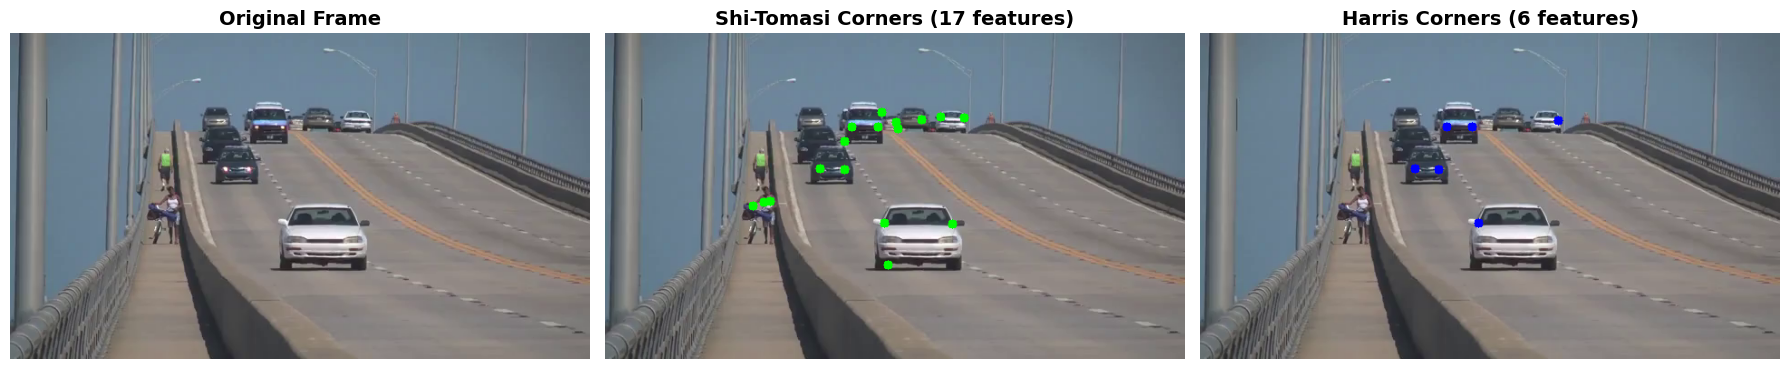

Shi-Tomasi detected: 17 features
Harris detected: 6 features


In [21]:
# Compare Shi-Tomasi vs Harris corner detection
cap = cv2.VideoCapture(VIDEO_INPUT)
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Shi-Tomasi (goodFeaturesToTrack)
corners_shi = cv2.goodFeaturesToTrack(gray, **feature_params)

# Harris corners (for comparison)
harris_params = feature_params.copy()
harris_params['useHarrisDetector'] = True
harris_params['k'] = 0.04
corners_harris = cv2.goodFeaturesToTrack(gray, **harris_params)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original
axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Frame', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Shi-Tomasi
frame_shi = frame.copy()
if corners_shi is not None:
    for corner in corners_shi:
        x, y = corner.ravel()
        cv2.circle(frame_shi, (int(x), int(y)), 5, (0, 255, 0), -1)
axes[1].imshow(cv2.cvtColor(frame_shi, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Shi-Tomasi Corners ({len(corners_shi)} features)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Harris
frame_harris = frame.copy()
if corners_harris is not None:
    for corner in corners_harris:
        x, y = corner.ravel()
        cv2.circle(frame_harris, (int(x), int(y)), 5, (255, 0, 0), -1)
axes[2].imshow(cv2.cvtColor(frame_harris, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'Harris Corners ({len(corners_harris)} features)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

cap.release()
print(f"Shi-Tomasi detected: {len(corners_shi)} features")
print(f"Harris detected: {len(corners_harris)} features")

### Experiment 2: Motion Statistics Visualization

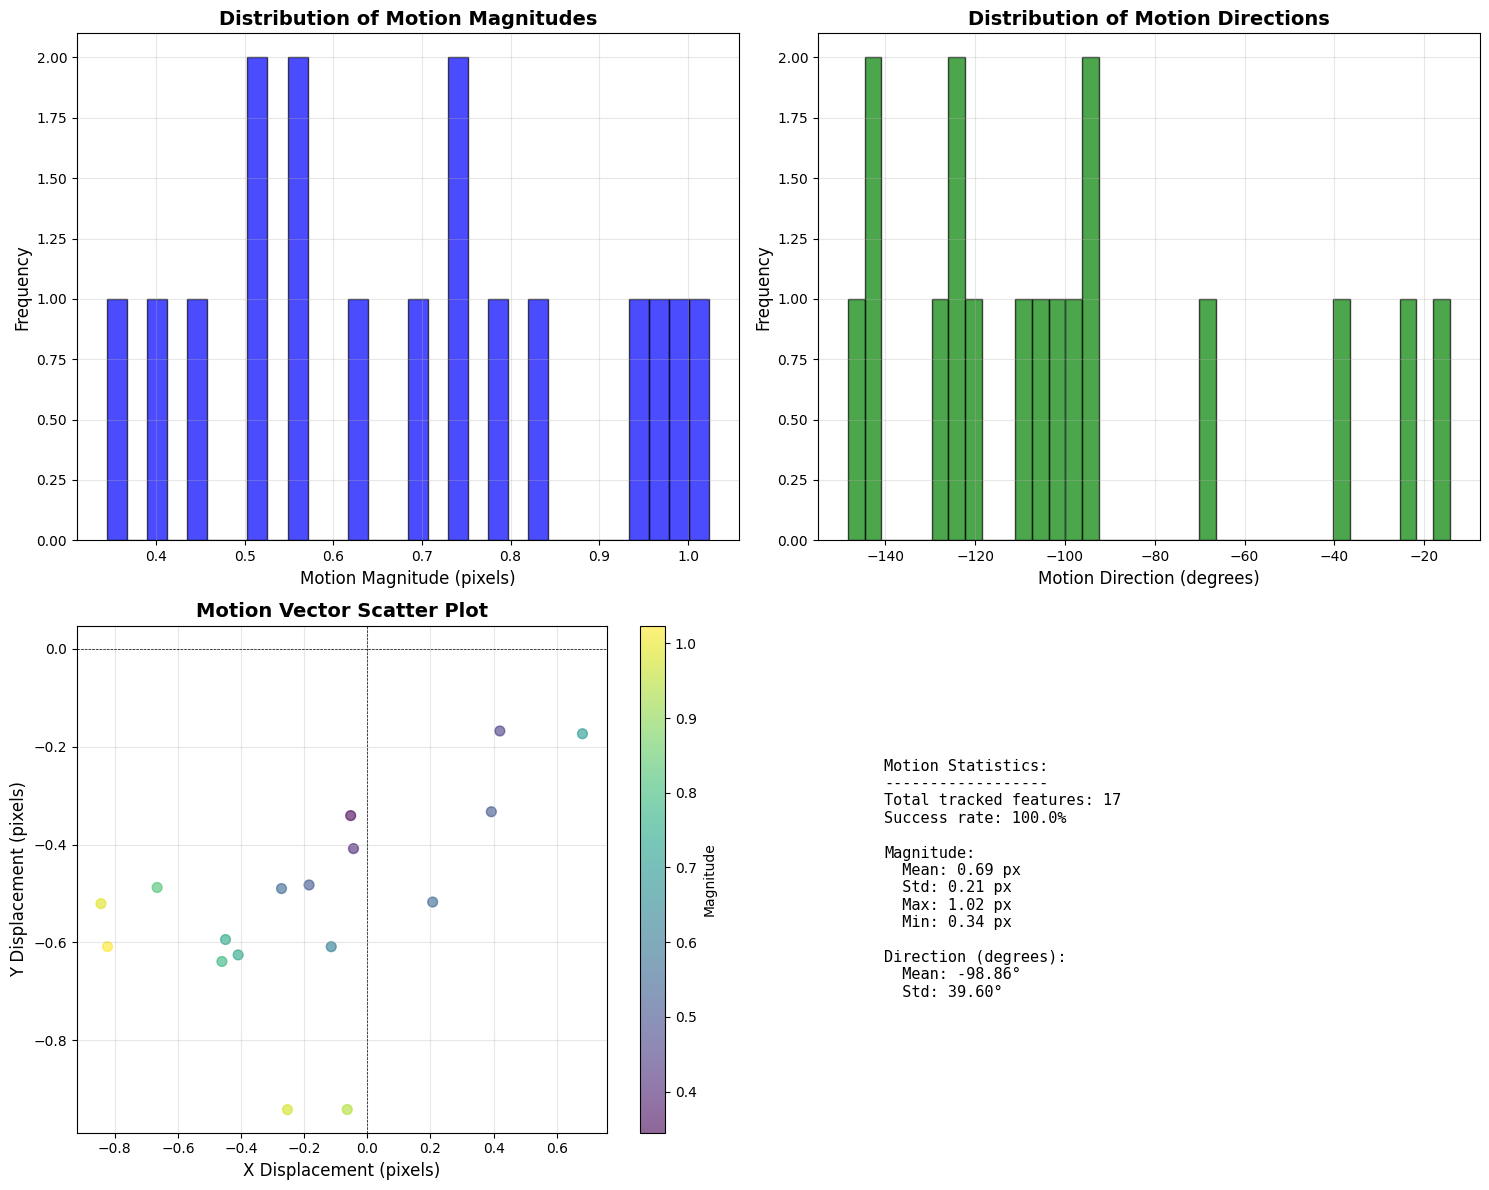

Motion statistics computed and visualized


In [22]:
# Analyze motion vectors from two consecutive frames
cap = cv2.VideoCapture(VIDEO_INPUT)
ret, frame1 = cap.read()
ret, frame2 = cap.read()

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Detect features
points1 = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# Track to next frame
points2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, points1, None, **lk_params)

# Filter good points
good_p1 = points1[status == 1]
good_p2 = points2[status == 1]

# Calculate motion vectors
motion_vectors = good_p2 - good_p1
magnitudes = np.linalg.norm(motion_vectors, axis=1)
angles = np.arctan2(motion_vectors[:, 1], motion_vectors[:, 0]) * 180 / np.pi

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Motion magnitude histogram
axes[0, 0].hist(magnitudes, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Motion Magnitude (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Motion Magnitudes', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Motion direction histogram
axes[0, 1].hist(angles, bins=36, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Motion Direction (degrees)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Motion Directions', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot of motion vectors
axes[1, 0].scatter(motion_vectors[:, 0], motion_vectors[:, 1], 
                   c=magnitudes, cmap='viridis', s=50, alpha=0.6)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
axes[1, 0].axvline(x=0, color='k', linestyle='--', linewidth=0.5)
axes[1, 0].set_xlabel('X Displacement (pixels)', fontsize=12)
axes[1, 0].set_ylabel('Y Displacement (pixels)', fontsize=12)
axes[1, 0].set_title('Motion Vector Scatter Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Magnitude', fontsize=10)

# 4. Statistics text
stats_text = f"""
Motion Statistics:
------------------
Total tracked features: {len(good_p1)}
Success rate: {len(good_p1)/len(points1)*100:.1f}%

Magnitude:
  Mean: {np.mean(magnitudes):.2f} px
  Std: {np.std(magnitudes):.2f} px
  Max: {np.max(magnitudes):.2f} px
  Min: {np.min(magnitudes):.2f} px

Direction (degrees):
  Mean: {np.mean(angles):.2f}°
  Std: {np.std(angles):.2f}°
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('motion_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

cap.release()
print("Motion statistics computed and visualized")